# Infer

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from tqdm import tqdm

from model.model import Transformer_fcst
from tools.infer import InferShortTerm, InferLongTerm
from tools.preprocess import make_input_target, make_src_tgt, cut_seq
from tools.train import make_loader

In [2]:
# infer config
src_len, tgt_len = 300, 10
run_name = 'fanciful-salad-1'
project_name = 'transformer_for_time_series_coin_data'

# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# test data
test = np.load('./data_coin/test.npy')
test = test[:, :, 1:2]
test = cut_seq(test, window_len=src_len + tgt_len, stride=20)

input, target = make_input_target(test, src_len, tgt_len)
test_dloader = make_loader(input, target, batch_size=128)

# sample test dloader for quick execution (especially in long-term forecasting)
size = input.shape[0] // 10
sample_idxs = np.random.choice(input.shape[0], size, replace=False)
input_sample, target_sample = input[sample_idxs], target[sample_idxs]
test_sample_dloader = make_loader(input_sample, target_sample, batch_size=128)

In [3]:
# model
model = Transformer_fcst(fcst_mode='gauss',
                         seq_len=(src_len, tgt_len),
                         embedding_dim=32,
                         nhead=16,
                         num_layers=(2, 2),
                         device=device,
                         ts_embed='wavenet',
                         pos_embed='fixed').to(device)
                         
model.load_state_dict(torch.load(f'./checkpoints/coin/{project_name}_{run_name}.pth'))
print(f'Load model from \n project name: {project_name} \n run name: {run_name}')

Load model from 
 project name: transformer_for_time_series_coin_data 
 run name: fanciful-salad-1


In [31]:
# infer objects
infershort = InferShortTerm(model)
inferlong = InferLongTerm(model)

## Short-term forecasting (i.e. rolling-timestep forecast)

### Eval

In [5]:
running_loss, running_metric = 0.0, 0.0
with torch.no_grad():
    for (input_batch, target_batch) in tqdm(test_dloader):
        input_batch, target_batch = input_batch.to(
            device), target_batch.to(device)
        src, tgt = make_src_tgt(input_batch, src_len, tgt_len)
        loss, metrics = infershort.eval((src, tgt), target_batch)

        running_loss += loss.item()
        running_metric += metrics[0].item()

print('Test loss:', running_loss / len(test_dloader))
print('Test metric(MAE):', running_metric / len(test_dloader))


100%|██████████| 744/744 [00:57<00:00, 13.02it/s]

Test loss: -5.136091315618125
Test metric(MAE): 0.002591899642626935


### Plot samples

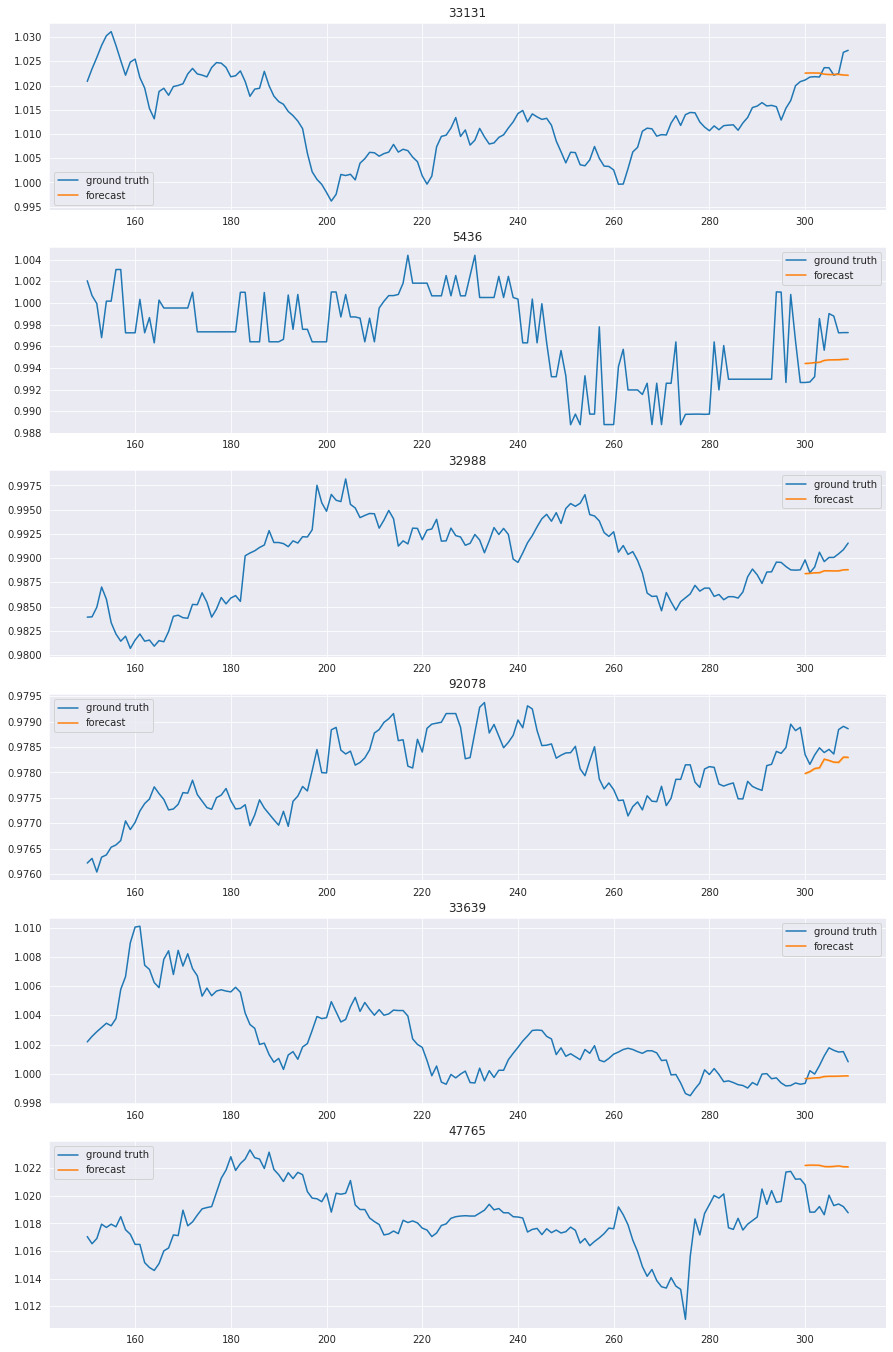

In [29]:
# canvas
fig, axes = plt.subplots(6,1, figsize=(15,24))

# sample indices (which are to be used again in long-term forecasting)
sample_idxs = np.random.choice(input.shape[0], len(axes), replace=False)

# sampling
input_sample, target_sample = input[sample_idxs], target[sample_idxs]
src, tgt = make_src_tgt(input_sample, src_len, tgt_len)

src, tgt = make_src_tgt(input_sample, src_len, tgt_len)

# plot
CUT_HEAD = 150
with torch.no_grad():
    src = torch.Tensor(src).to(device)
    tgt = torch.Tensor(tgt).to(device)
    target_sample = torch.Tensor(target_sample).to(device)
    infershort.plot((src,tgt), target_sample, axes, cut_head=CUT_HEAD)

# set index number as a title
for idx, ax in zip(sample_idxs, axes):
    ax.set_title(idx)

## Long-term forecasting (i.e. with recurrence)
> The code is identical to short-term forecasting. Only difference is to use InferLongTerm instead of InferShortTerm.

### Eval
> Use only a part of data, due to its long infer time.

In [8]:
running_loss, running_mae, running_hit_ratio = 0.0, 0.0, 0.0
with torch.no_grad():
    for (input_batch, target_batch) in tqdm(test_sample_dloader):
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)
        src, tgt = make_src_tgt(input_batch, src_len, tgt_len)
        loss, metrics = inferlong.eval((src, tgt), target_batch)
        
        running_loss += loss.item()
        running_mae += metrics[0].item()

print('Test loss:', running_loss / len(test_sample_dloader))
print('Test metric(MAE):', running_mae / len(test_sample_dloader))

100%|██████████| 75/75 [09:28<00:00,  7.57s/it]

Test loss: -5.115760326385498
Test metric(MAE): 0.002643826863107582


### Plot samples

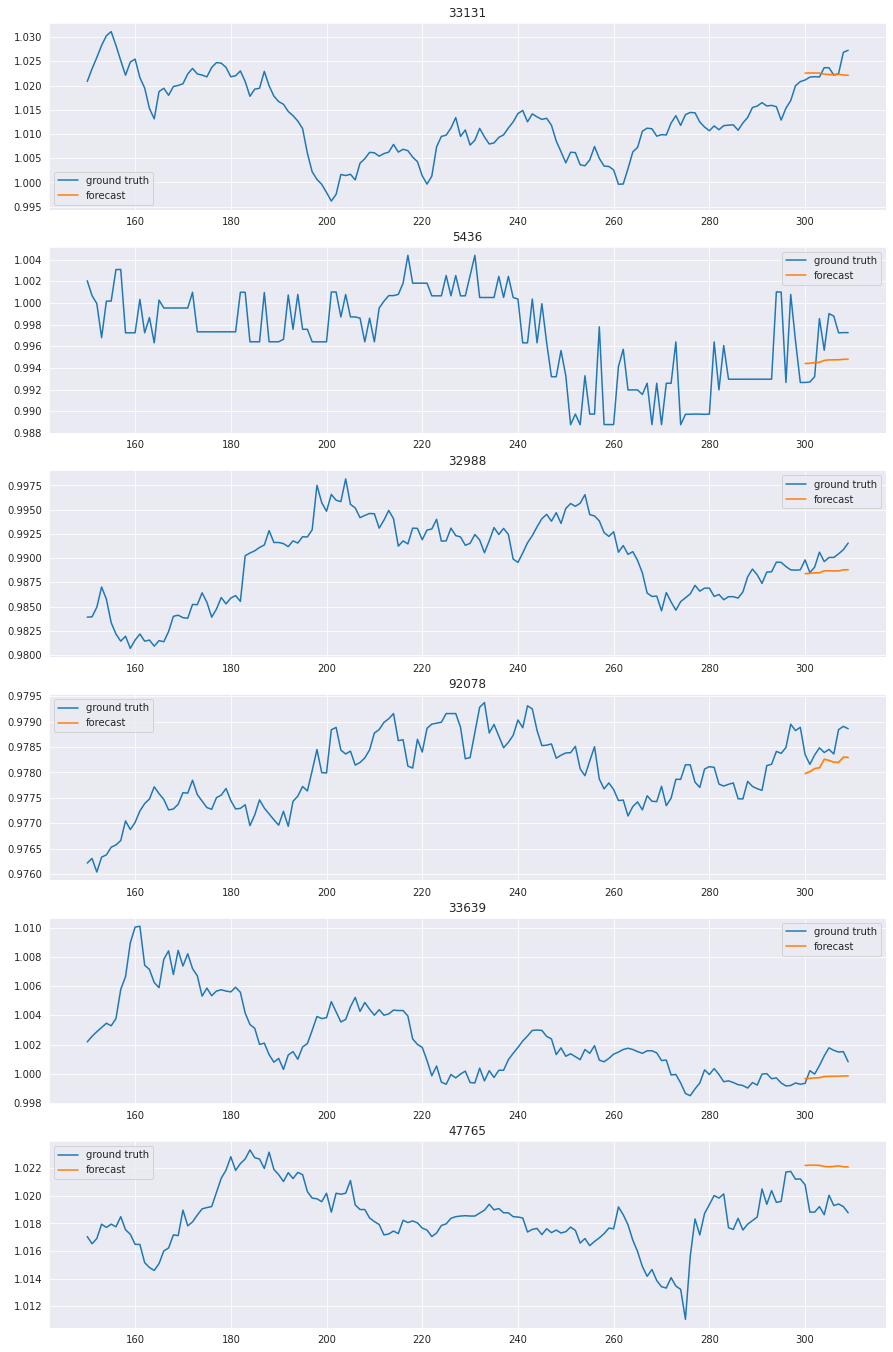

In [30]:
# canvas
fig, axes = plt.subplots(6, 1, figsize=(15, 24))

# sampling
input_sample, target_sample = input[sample_idxs], target[sample_idxs]

src, tgt = make_src_tgt(input_sample, src_len, tgt_len)

# plot
with torch.no_grad():
    src = torch.Tensor(src).to(device)
    tgt = torch.Tensor(tgt).to(device)
    target_sample = torch.Tensor(target_sample).to(device)
    inferlong.plot((src, tgt), target_sample, axes, cut_head=CUT_HEAD)

# set index number as a title
for idx, ax in zip(sample_idxs, axes):
    ax.set_title(idx)